In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import load_model
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
n_labels = 46
dim = 32
model_path = 'dev_new.h5'

In [3]:
train_path = 'Train'
test_path = 'Test'
# imdir = 'test'
# if not os.path.isdir(imdir):
#     os.mkdir(imdir)

labels = [folder for folder in os.listdir('./'+train_path) if 'character_' or 'digit_' in folder]

# n = 0
# for folder in labels:
#     for imfile in os.scandir('./'+test_path+folder):
#         os.rename(imfile.path, os.path.join(imdir, '{:06}.png'.format(n)))
#         n += 1

In [4]:
def MyModel(input_shape):
    """
    Implementation of the MyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape)

    #x = Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', use_bias=False,activation='relu')(X_input)
    x = Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', use_bias=False)(X_input)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    #x = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_2', use_bias=False,activation='relu')(x)
    x = Conv2D(64, (5,5), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    x = Flatten()(x)
    x = Dense(8*8*64, activation='relu', name='fc')(x)
    x = Dense(n_labels, activation='softmax', name='fc_classifier')(x)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = x, name='MyModel')
    
    return model

In [5]:
dev_model = MyModel((dim,dim,3))

In [6]:
dev_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 32)        2400      
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 64)        51200     
_________________________________________________________________
norm_2 (BatchNormalization)  (None, 16, 16, 64)        256       
__________

In [7]:
img_width, img_height = dim, dim
batch_size = 128
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        validation_split=0.2)


train_generator = train_datagen.flow_from_directory('./Train',
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    subset='training',
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory('./Train',
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    subset='validation',
                                                    class_mode='categorical')

Found 62560 images belonging to 46 classes.
Found 15640 images belonging to 46 classes.


In [8]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.0001, 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [9]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('./logs/')) if 'dev_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('./logs/') + 'dev_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)
optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [10]:
dev_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ["accuracy"])

In [11]:
history = dev_model.fit_generator(train_generator,
              epochs=50,
              validation_data=validation_generator,
              callbacks = [early_stop])

Epoch 1/50
489/489 [==============================] - 197s 402ms/step - loss: 1.6479 - acc: 0.5587 - val_loss: 1.5418 - val_acc: 0.5811
Epoch 2/50
489/489 [==============================] - 181s 370ms/step - loss: 0.7650 - acc: 0.7890 - val_loss: 1.1376 - val_acc: 0.6779
Epoch 3/50
489/489 [==============================] - 181s 370ms/step - loss: 0.5118 - acc: 0.8596 - val_loss: 0.8877 - val_acc: 0.7429
Epoch 4/50
489/489 [==============================] - 182s 372ms/step - loss: 0.3863 - acc: 0.8926 - val_loss: 0.7968 - val_acc: 0.7707
Epoch 5/50
489/489 [==============================] - 181s 370ms/step - loss: 0.3061 - acc: 0.9160 - val_loss: 0.6922 - val_acc: 0.7990
Epoch 6/50
489/489 [==============================] - 181s 370ms/step - loss: 0.2593 - acc: 0.9270 - val_loss: 0.6271 - val_acc: 0.8187
Epoch 7/50
489/489 [==============================] - 181s 370ms/step - loss: 0.2225 - acc: 0.9371 - val_loss: 0.6096 - val_acc: 0.8208
Epoch 8/50
489/489 [============================

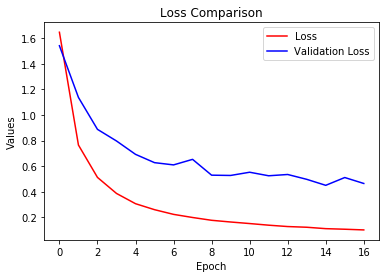

In [12]:
plt.plot(history.history["loss"],color = 'red', label = 'Loss')
plt.plot(history.history["val_loss"],color = 'blue', label = 'Validation Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.legend()
plt.show()

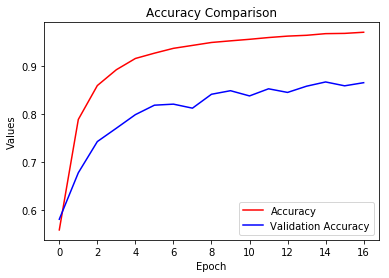

In [13]:
plt.plot(history.history["acc"],color = 'red', label = 'Accuracy')
plt.plot(history.history["val_acc"],color = 'blue', label = 'Validation Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Values')
plt.legend()
plt.show()

In [14]:
dev_model.save(model_path)

In [15]:
dev_model = load_model(model_path)

character_25_ma: 98.92%


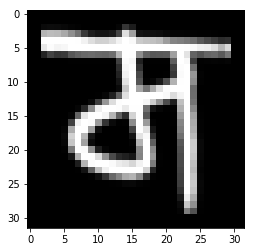

In [38]:
import cv2
import random
import re
from keras.preprocessing.image import img_to_array
n= random.randint(0,13799)
test_image = cv2.imread('./test/'+'{:06}.png'.format(n))
input_image = cv2.resize(test_image, (dim, dim))
plt_image = input_image
input_image = input_image.astype("float") / 255.0
input_image = img_to_array(input_image)
input_image = np.expand_dims(input_image, 0)
results = dev_model.predict(input_image)
label = "{}: {:.2f}%".format(labels[np.argmax(results)], results[0,np.argmax(results)] * 100)
print(label)
plt.imshow(plt_image); plt.show()